## Goal
Using Amazon Food reviews
1. Featurize/Vectorize - BoW, tfIDF
2. Preprocess
3. Train/Test split using time based slicing as a 70-30 split
4. For BoW and TfIDF:
   1. Use 10-fold cross validation to find optimal/best alpha in Multinomial NB
   2. Report list of important features for both +ve and -ve reviews
   3. Report test accuracy, Confusion Matrix, Precision, Recall, F1Score, TPR, FPR, FNR and TNR with the best alpha


### Data
The Amazon fine food reviews dataset is available [here](https://www.kaggle.com/snap/amazon-fine-food-reviews/downloads/database.sqlite/2). The SQLLite version(database.sqlite) of the dataset is used. A folder called 'amazon-fine-food-reviews' needs to be created in the working directory and downloaded to that folder.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer, accuracy_score
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD

import itertools, pickle, random, sqlite3, nltk, string, re
from pathlib import Path
from scipy import sparse

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec, KeyedVectors

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Load Data

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not considering those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [3]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#change reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print ('Total number of reviews is {} with {} features each'.format(*filtered_data.shape))
filtered_data.head()

Total number of reviews is 525814 with 10 features each


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### EDA

#### Remove Duplicates

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#### Data Cleanup

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#### Note:
The dataset is imbalanced. So the metric to evaluate the model should not be accuracy, it could be confusion matrix 

### PreProcessing

#### Stemming, Stop word remove and Lemmatization

In [6]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print('The stop words are \n {}'.format(stop))
print('************************************************************')
print('The stem word for tasty is {}'.format(sno.stem('tasty')))

The stop words are 
 {'where', 'off', 'after', 'before', 'having', 'yourself', 'am', 'do', 'o', "she's", 'down', "shan't", 'through', 'below', 'aren', 'same', "it's", 'wasn', 'too', 'if', 'nor', 'have', 'very', 'more', 'and', "wouldn't", "that'll", "you'll", 'herself', 'those', 'hers', "wasn't", "weren't", 'other', 'will', 'or', 'again', 'not', 'isn', 'so', "mightn't", 'but', 'in', 'only', 'weren', 'out', 'be', 'she', 've', 'you', 'needn', "couldn't", 'was', 'what', 'didn', 'me', 'himself', "aren't", 'mightn', 'for', 'of', 'these', 'here', 'wouldn', 'hadn', 'has', "you'd", 't', 'now', 'can', 'ain', 'because', 'had', 'mustn', 'he', 'whom', 'y', 'this', 'own', 'at', 'they', 'i', 'few', 'than', 'did', 'our', "doesn't", 'theirs', "isn't", 'does', 'haven', 'is', 'doesn', 'under', "mustn't", 'up', 'no', 'my', 'your', 'are', 'who', 'about', 'on', 'how', 'shouldn', 'a', 'until', 'their', 'from', 'couldn', 'yourselves', 'his', 'some', 'an', 'against', 'each', 'shan', 'ma', 'all', 'which', 'over

We need 3 types of cleaned data so we will use 3 different variables to store this data:
1. For Bag of Words and TfIDF we need the stop words to be removed and stemmed
2. For Bigrams and trigrams we do not need to remove the stop words but we can stem the words
3. For Avg Word2Vec and TfIDF Word2Vec we can remove the stopwords but not stem the words if we plan to use Google's word2vec model.

In [7]:
i=0
str_b=' '
bow_tfidf_string=[]
s=''
for sent in final['Text'].values:
    filtered_sentence_b=[]
    
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): 
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                if(cleaned_words.lower() not in stop):
                    filtered_sentence_b.append(s) #for BoW and tfidf we need stemmed and stop words removed data
                else:
                    continue
            else:
                continue 
    
    
    str_b = b" ".join(filtered_sentence_b)
    
    bow_tfidf_string.append(str_b)

    i+=1

In [8]:
final['BowTfIDFText']=bow_tfidf_string 
final['BowTfIDFText']=final['BowTfIDFText'].str.decode("utf-8")

In [9]:
# store final table into an SQlLite table for future.
final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
c=final_dbconn.cursor()
final_dbconn.text_factory = str
final.to_sql('Reviews', final_dbconn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

### Train and Predict Model

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          figsize = (5,3),
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     plt.figure(figsize=(4,2))
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

### Run Classifier
Given a dataset of X, y the below function
1. Splits the dataset into train and test.
2. Executes NB classifier.
3. Executes the classifier for varying values of 'alpha'.
4. Calculates the optimal 'alpha' value from the above step.
5. Uses the optimal 'alpha' value to run the classifier against the test dataset.

In [20]:
def split_data(data, sort_by_time='Y', test_size=0.3):
    
    if sort_by_time == 'Y':
        data = data.sort_values(by='Time')
        data.reset_index(inplace=True,drop=True)
        
    train_index = int(np.floor(data.shape[0] * (1- test_size)))

    X_train = data.loc[:train_index]
    y_train = X_train.Score
    X_train.drop(['Score'], axis=1, inplace=True)
    

    X_test = data.loc[train_index:]
    y_test = X_test.Score
    X_test.drop(['Score'], axis=1, inplace=True)
    
    return X_train, y_train, X_test, y_test

def plot_cv_scores(gridsearch, x_axis_label, y_axis_label, title):
    X = [mean for mean in gridsearch.cv_results_['mean_test_score']]
    y = [params['alpha'] for params in gridsearch.cv_results_['params']]
    
    plt.plot(X, y)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    
    plt.title(title)
    plt.grid() 

    plt.show()

def run_classifier(data, vectorize_technique, k=5):
    if vectorize_technique not in ['bow', 'tfidf']:
        print ('Allowed vectorization techniques are Bag Of Words(BoW) and TF-IDF(tfidf)')
        return
    
    X_train, y_train, X_test, y_test = split_data(data, sort_by_time='Y')
    
    #Create X_train with just the vectors
    if vectorize_technique == 'bow':
        X_train, X_test, vectorizer = vectorize_bow(X_train, X_test)
    elif vectorize_technique == 'tfidf':
        X_train, X_test, vectorizer = vectorize_tfidf(X_train, X_test)
        
    cv = 10
    #Use TimeSeriesSplit for cross validation
    tscv = TimeSeriesSplit(n_splits=cv)
    
#     alphas =[1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
    alphas = [10**-4, 10**-2, 10**0, 10**2, 10**3]
    
    param_grid = {'alpha': alphas}
    mnb_clf = MultinomialNB()
    
    print ('-' *80)
    train_test_split = tscv.split(X_train)
    print ('Doing Gridsearch .....')
    f1_scorer = make_scorer(f1_score, pos_label='positive')
#     accuracy_scorer = make_scorer(accuracy_score, pos_label='positive')
    
#     scoring = {'f1_score': 'f1', 'Accuracy': 'accuracy'}
    
    gs = GridSearchCV(mnb_clf, param_grid, cv = train_test_split, n_jobs=-1,verbose=5, scoring= 'accuracy')
    gs.fit(X_train, y_train)
    print ('Calculating best score from grid search. Metric used is Accuracy')
    print ('Best Accuracy score: ', gs.best_score_)
    
    print ('Best parameters set from Accuracy Score:')
    best_parameters = gs.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print (param_name, best_parameters[param_name])

    plot_cv_scores(gs, 'Accuracy', 'Alphas', 'Plot of CV Accuracy Scores')
    
    train_test_split = tscv.split(X_train)
    gs = GridSearchCV(mnb_clf, param_grid, cv = train_test_split, n_jobs=-1,verbose=5, scoring= f1_scorer)
    gs.fit(X_train, y_train)
    print ('Calculating best score from grid search. Metric used is F1 Score.')
    print ('Best F1 score: ', gs.best_score_)

    print ('Best parameters set from F1 Score:')
    best_parameters = gs.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print (param_name, best_parameters[param_name])
    
    plot_cv_scores(gs, 'F1 Scores', 'Alphas', 'Plot of CV F1 Scores')
    
    print ('Dimensions of X_test is {} and y_test is {}'.format (X_test.shape, y_test.shape))
    print ('Predicting with X_test with parameters from F1 Score.....')
    
    alpha = best_parameters['alpha']
    mnb_clf = MultinomialNB(alpha=alpha)
    mnb_clf.fit(X_train, y_train)
    y_pred = mnb_clf.predict(X_test)
    
    print ('Classification report is .....')
    print (classification_report(y_test, y_pred))
    print ('Confusion Matrix is .....')
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['Negative', 'Positive'])
    
    neg_class_prob_sorted = mnb_clf.feature_log_prob_[0, :].argsort()
    pos_class_prob_sorted = mnb_clf.feature_log_prob_[1, :].argsort()

    print('The top 10 negative words are {}'.format(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[-10:])))
    print('The top 10 positive words are {}'.format(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[-10:])))

## Bag of Words

In [4]:
def get_bow_tfidfdata(no_of_records = 2000):
    #The original dataset has approximately 85% positive reviews and 15% negative reviews, so we will use the same % to make
    #a subset 
    pos_limit = int(no_of_records * 0.85)
    neg_limit = no_of_records - pos_limit

    final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
    final_dbconn.text_factory = str

    pos_qry = "SELECT time, BowTfIDFText, Score FROM Reviews where Score = 'positive' LIMIT " + str(pos_limit)
    pos_reviews = pd.read_sql_query(pos_qry, final_dbconn) 
    print('Positive reviews shape is {}'.format(pos_reviews.shape))

    neg_qry = "SELECT time, BowTfIDFText, Score FROM Reviews where Score = 'negative' LIMIT " + str(neg_limit)
    neg_reviews = pd.read_sql_query(neg_qry, final_dbconn) 
    print('Negative reviews shape is {}'.format(neg_reviews.shape))

    frames = [pos_reviews, neg_reviews]

    data = pd.concat(frames, ignore_index=True)
    print('Both positive and negative reviews combined together contains {} reviews'.format(data.shape[0]))
    return data

In [5]:
def vectorize_bow(X_train, X_test):
    #Vectorize the reviews
    count_vect = CountVectorizer() 
    
    #Build vocabulary from X_train
    X_train_counts = count_vect.fit_transform(X_train['BowTfIDFText'].values)
    X_test_counts = count_vect.transform(X_test['BowTfIDFText'].values)
    
    print("Shape of vectorized train and test datasets are {} and {}".format(X_train_counts.get_shape(), X_test_counts.get_shape()) )
    print("Number of unique words in the dataset is ", X_train_counts.get_shape()[1])
    print ('Type of bow_counts ', type(X_train_counts))
    
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized Bag of Words review contains {} records with {} features each'.format(*X_train_std_data.shape))

    #vectorize the test set with the same vocabulary as train data set
    print("The shape of our BOW vectorized test dataset is {}".format(X_test_counts.get_shape()))

    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data, count_vect

Positive reviews shape is (307061, 3)
Negative reviews shape is (54626, 3)
Both positive and negative reviews combined together contains 361687 reviews
Shape of vectorized train and test datasets are (253181, 58985) and (108507, 58985)
Number of unique words in the dataset is  58985
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized Bag of Words review contains 253181 records with 58985 features each
The shape of our BOW vectorized test dataset is (108507, 58985)
--------------------------------------------------------------------------------
Doing Gridsearch .....
Fitting 10 folds for each of 5 candidates, totalling 50 fits


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   18.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.6s finished


Calculating best score from grid search. Metric used is Accuracy
Best Accuracy score:  0.8163972888425444
Best parameters set from Accuracy Score:
alpha 1000


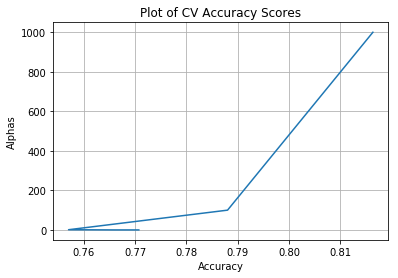

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   22.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.6s finished


Calculating best score from grid search. Metric used is F1 Score.
Best F1 score:  0.8962903214016951
Best parameters set from F1 Score:
alpha 1000


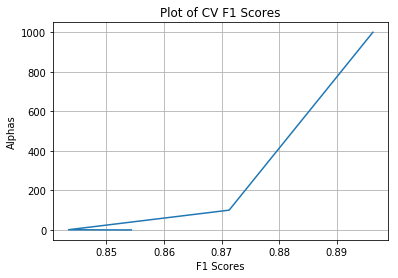

Dimensions of X_test is (108507, 58985) and y_test is (108507,)
Predicting with X_test with parameters from F1 Score.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.52      0.13      0.20     17116
   positive       0.86      0.98      0.91     91391

avg / total       0.80      0.84      0.80    108507

Confusion Matrix is .....


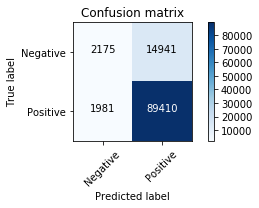

The top 10 negative words are ['money' 'tri' 'buy' 'bad' 'one' 'would' 'disappoint' 'product' 'like'
 'tast']
The top 10 positive words are ['make' 'flavor' 'use' 'one' 'tri' 'tast' 'like' 'good' 'love' 'great']


In [21]:
no_of_records=364171
data = get_bow_tfidfdata(no_of_records)
run_classifier(data, vectorize_technique ='bow')

## TF-IDF

In [16]:
def vectorize_tfidf(X_train, X_test):
    #Vectorize the reviews
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
    
    #Build vocabulary from X_train
    X_train_counts = tf_idf_vect.fit_transform(X_train['BowTfIDFText'].values)
    X_test_counts = tf_idf_vect.transform(X_test['BowTfIDFText'].values)
    
    print("Shape of vectorized train and test datasets are {} and {}".format(X_train_counts.get_shape(), X_test_counts.get_shape()) )
    print("Number of unique words in the dataset is ", X_train_counts.get_shape()[1])
    print ('Type of bow_counts ', type(X_train_counts))
    
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized Bag of Words review contains {} with {} features each'.format(*X_train_std_data.shape))
    
    #vectorize the test set with the same vocabulary as train data set
    print("The shape of vectorized test dataset is {}".format(X_test_counts.get_shape()))
    
    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data, tf_idf_vect

Positive reviews shape is (307061, 3)
Negative reviews shape is (54626, 3)
Both positive and negative reviews combined together contains 361687 reviews
Shape of vectorized train and test datasets are (253181, 58985) and (108507, 58985)
Number of unique words in the dataset is  58985
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized Bag of Words review contains 253181 with 58985 features each
The shape of vectorized test dataset is (108507, 58985)
--------------------------------------------------------------------------------
Doing Gridsearch .....
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   19.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.4s finished


Calculating best score from grid search. Metric used is Accuracy
Best Accuracy score:  0.8141379909628085
Best parameters set from Accuracy Score:
alpha 1000


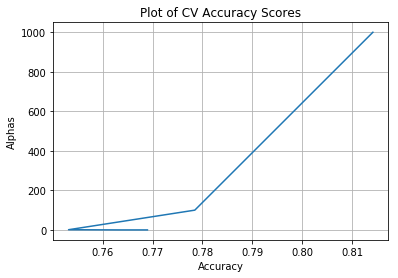

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   21.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.6s finished


Calculating best score from grid search. Metric used is F1 Score.
Best F1 score:  0.8942707467936859
Best parameters set from F1 Score:
alpha 1000


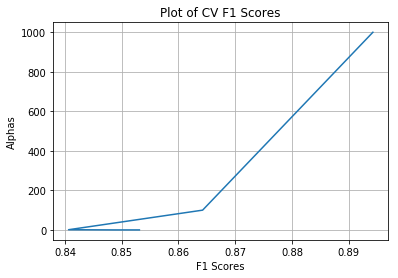

Dimensions of X_test is (108507, 58985) and y_test is (108507,)
Predicting with X_test with parameters from F1 Score.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.55      0.15      0.23     17116
   positive       0.86      0.98      0.91     91391

avg / total       0.81      0.85      0.81    108507

Confusion Matrix is .....


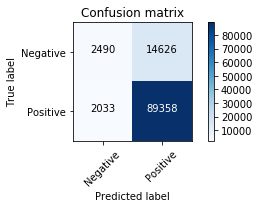

The top 10 negative words are ['wast' 'return' 'tri' 'one' 'bad' 'would' 'product' 'disappoint' 'like'
 'tast']
The top 10 positive words are ['make' 'tri' 'one' 'use' 'flavor' 'good' 'tast' 'great' 'like' 'love']


In [22]:
no_of_records=364171
data = get_bow_tfidfdata(no_of_records)
run_classifier(data, vectorize_technique ='tfidf')

|Model|Hyper Parameter|F1 Train Error|F1 Test Error|
| ------------- |:-------------:| -----:|-----:|
|NaiveBayes - BoW| alpha(laplace smoothing)=1000 | 10%| 20% |
|NaiveBayes - TfIDF|alpha=1000 |  11%|19% |
